# Hyperparameter Tuning

##일반적으로 결과가 안 좋을 때 할 수 있는 방법
1. 모델을 바꿔본다.
2. 데이터를 바꿔본다.(데이터 추가 or 데이터 오류 찾아보기)
3. 하이퍼파라미터 튜닝

이 중에서 가장 좋은 성능을 내는 것은 **2. 데이터를 바꾸는 것이다.** 1. 모델은 좋은 것을 많이 알고 있기 때문에 그렇게 중요하지 않다고 말한다.
그 다음으로 좋은 방법은 3. 하이퍼 파라미터 튜닝이다. 이 방법으로 인해 큰 성능향상은 어렵지만 마른 수건도 짜보자 라는 식으로 해보는 것이다.

#### 하이퍼 파라미터 튜닝
- 모델 스스로 학습하지 않는 값은 사람이 지정한다(learning rate, 모델의 크기, optimizer 등)
- 하이퍼 파라미터에 의해서 값이 크게 좌우 될 때도 있다.
- 마지막 0.01을 쥐어짜야 할 때 도전해볼만 하다.

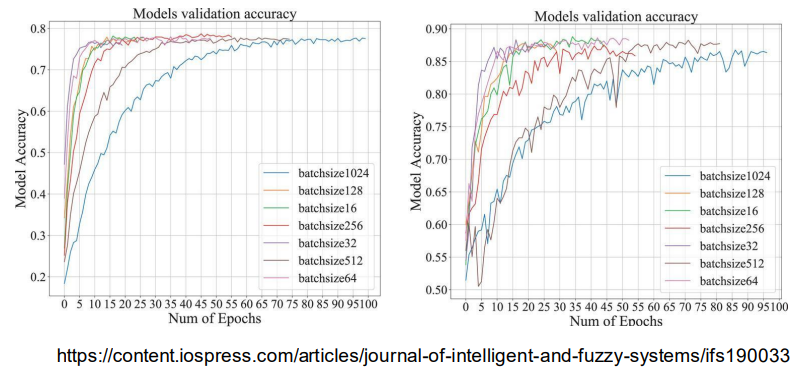

위 사진처럼 하이퍼 파라미터 튜닝을 통해 성능이 차이나는 것을 확인했기 때문에 해볼 만 하다!

- 가장 기본적인 방법 - grid vs random -> 올드스쿨 스타일
- 최근에는 베이지안 기반 기법들이 주도한다. -> BOHB
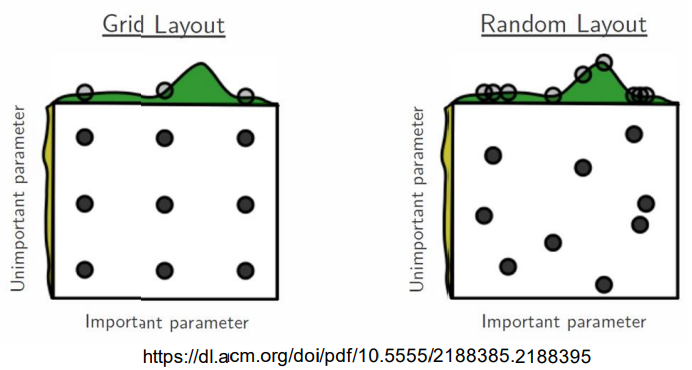

# Ray
- multi-node multi processing 지원 모듈
- ML/DL의 병렬 처리를 위해 개발된 모듈
- 기본적으로 현재의 분산병렬 ML/DL 모듈의 표준
- Hyperparameter Search를 위한 다양한 모듈 제공

In [ ]:
# Example

data_dir = os.path.abspath("./data")
load_data(data_dir)

config = { # 파라미터 값으로 줄 것들을 config에 저장
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)), 
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
        }

scheduler = ASHAScheduler( # 에포크를 진행하면서 성능이 좋아지지 않을 것들은 걸러내는 역할 => 효율적
    metric="loss", mode="min", max_t=max_num_epochs, grace_period=1,
    reduction_factor=2)

# 결과 출력 양식을 지정한다.
reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])

# 병럴 처리 양식으로 학습을 시행한다.
result = tune.run(partial(train_cifar, data_dir=data_dir),
                resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                config=config, 
                num_samples=num_samples,
                scheduler=scheduler,
                progress_reporter=reporter)

scheduler :아래 사진처럼 학습을 진행하면서 가망이 없는 것들은 계속 학습을 하지 않고 걸러낸다. 효율적인 수행 가능.
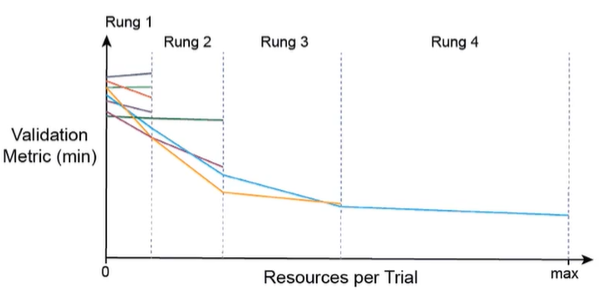

# Ray_tune

In [1]:
!pip install ray
!pip install tensorboardX

     |████████████████████████████████| 57.6 MB 1.2 MB/s 
     |████████████████████████████████| 173 kB 49.0 MB/s 
     |████████████████████████████████| 124 kB 4.1 MB/s 


In [2]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [3]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset


In [4]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)

        # 아래의 l1, l2를 하이퍼 파라미터 튜닝으로 넣는다!
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [6]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.suggest.hyperopt import HyperOptSearch

def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    
#-------------------------------------------------------------------------------
    # 중요한거 1
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    # 중요한거 2
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    # 중요한거 3
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    

    # 중요한거 4
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)
#-------------------------------------------------------------------------------
    # 가장 높은 성능을 내는 모델을 불러오기??
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    # ray를 이용하면 튜닝을 하면 쉽게 파라미터를 찾을 수 있고 
    # 그 값을 가지고 다시 리턴해서 쓸 수 있다.
    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)


    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)